In [367]:
import pandas as pd

In [368]:
# !pip install ludwig

In [369]:
# !pip install -U scikit-learn


In [370]:
# !pip install ptitprince

In [371]:
# !pip install seaborn==0.11.1

In [372]:
url = 'https://raw.githubusercontent.com/john-adeojo/womartdata/main/TRAIN.csv'
df = pd.read_csv(url)
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [373]:
df.describe(include='all')

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
count,188340,188340.000000,188340,188340,188340,188340,188340.000000,188340,188340.000000,188340.000000
unique,188340,NaN,4,5,4,516,NaN,2,NaN,NaN
top,T1000001,NaN,S1,L1,R1,2018-01-01,NaN,No,NaN,NaN
freq,1,NaN,88752,85140,63984,365,NaN,104051,NaN,NaN
mean,NaN,183.000000,NaN,NaN,NaN,NaN,0.131783,NaN,68.205692,42784.327982
std,NaN,105.366308,NaN,NaN,NaN,NaN,0.338256,NaN,30.467415,18456.708302
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000
25%,NaN,92.000000,NaN,NaN,NaN,NaN,0.000000,NaN,48.000000,30426.000000
50%,NaN,183.000000,NaN,NaN,NaN,NaN,0.000000,NaN,63.000000,39678.000000
75%,NaN,274.000000,NaN,NaN,NaN,NaN,0.000000,NaN,82.000000,51909.000000


In [374]:
df[['Store_id','#Order']].groupby('Store_id').describe()

#Order                                                         
          count        mean        std   min   25%    50%     75%    max
Store_id                                                                
1         516.0   59.124031  18.356770   6.0  49.0   59.0   70.00  116.0
2         516.0   76.197674  21.098927   6.0  65.0   76.0   87.25  183.0
3         516.0  115.284884  30.555667  13.0  99.0  114.0  128.00  284.0
4         516.0   64.877907  16.516500   6.0  57.0   66.0   74.00  139.0
5         516.0   68.304264  14.451206   8.0  60.0   66.5   77.00  125.0
...         ...         ...        ...   ...   ...    ...     ...    ...
361       516.0   55.647287  14.970898   5.0  46.0   54.0   64.00  118.0
362       516.0   56.926357  15.313374   7.0  50.0   58.0   66.00  115.0
363       516.0   67.631783  15.863375   6.0  58.0   66.0   77.00  149.0
364       516.0   45.806202  11.171272   4.0  38.0   45.0   53.00   83.0
365       516.0   44.515504  13.438019   4.0  37.0   44.0   52.00  104.0

[365 rows x 8 columns]

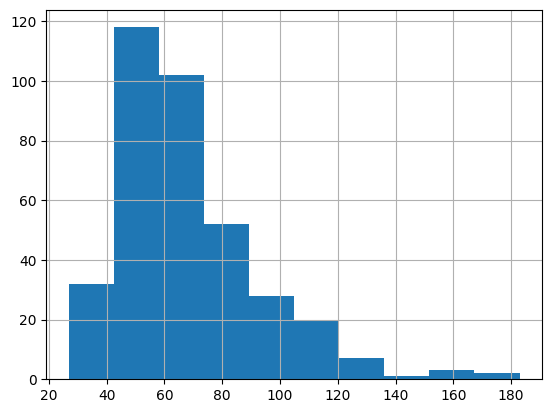

In [375]:
df.groupby('Store_id')['#Order'].mean().hist()
plt.show()

<Axes: >

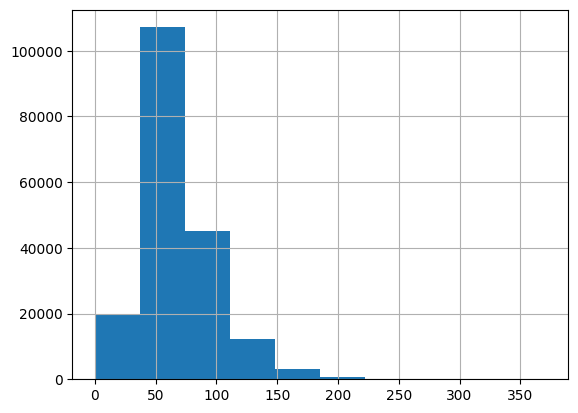

In [376]:
df['#Order'].hist()

In [377]:
# Data set splitting
import numpy as np
import hashlib

def split_data(df):
  # Create a new column 'hash_val' that is the hash of the 'Store_id' column
  df['hash_val'] = df['Store_id'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))

  # Use the 'hash_val' column to create a boolean mask for the holdout set
  is_holdout = df['hash_val'] % 10 < 2  # Approximately 20% will be in the holdout set

  # Create the holdout and train sets
  holdout_set = df[is_holdout].copy()
  train_set = df[~is_holdout].copy()

  # Add a 'set' column to each set
  holdout_set['set'] = 'hold_out'
  train_set['set'] = 'train'

  df_all = pd.concat([holdout_set, train_set], axis=0)

  return train_set, df_all

train_set, df_all = split_data(df)

In [378]:
def number_encode(df):
    # Convert 'Discount' column to binary
  df['Discount'] = df['Discount'].map({'Yes': 1, 'No': 0}).astype(int)

  # Encode Store Type
  df['Store_Type_enc'] = df['Store_Type'].map({'S1': 0, 'S2': 1, 'S3': 2, 'S4': 4}).astype(int)

  # Encode Location_Type
  df['Location_Type_enc'] = df['Location_Type'].map({'L1': 0, 'L2': 1, 'L3': 2, 'L4': 4, 'L5': 5}).astype(int)

  # Encode Location_Type
  df['Region_Code_enc'] = df['Region_Code'].map({'R1': 0, 'R2': 1, 'R3': 2, 'R4': 4}).astype(int)

  # Convert 'Date' to datetime
  df['Date'] = pd.to_datetime(df['Date'])

  # Create 'DayOfWeek' and 'MonthOfYear'
  df['DayOfWeek'] = df['Date'].dt.dayofweek
  df['MonthOfYear'] = df['Date'].dt.month

  return df

train_set_encoded = number_encode(train_set)
all_set_encoded = number_encode(df_all)

In [379]:
from sklearn.preprocessing import StandardScaler

# Sequence Features
sequence_features = ['Sales', 'DayOfWeek', 'MonthOfYear']


# initialize a standard scaler
scaler = StandardScaler()

# copy the original Sales column to a new column Sales_original
train_set_encoded['Orders_original'] = train_set_encoded['#Order']
all_set_encoded['Orders_original'] = all_set_encoded['#Order']

# fit the scaler on the training set (excluding 'Sales' because we want to preserve it as the label)
scaler.fit(train_set_encoded[sequence_features])

# transform both the training set and the holdout set
train_set_encoded[sequence_features] = scaler.transform(train_set_encoded[sequence_features])
all_set_encoded[sequence_features] = scaler.transform(all_set_encoded[sequence_features])

# now add 'Sales' to the sequence_features list and fit and transform 'Sales' separately
scaler.fit(train_set_encoded[['#Order']])
train_set_encoded['#Order'] = scaler.transform(train_set_encoded[['#Order']])
all_set_encoded['#Order'] = scaler.transform(all_set_encoded[['#Order']])

In [380]:
all_set_encoded.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,hash_val,set,Store_Type_enc,Location_Type_enc,Region_Code_enc,DayOfWeek,MonthOfYear,Orders_original
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,-1.517885,-1.272747,9017500930054051502567433507221030433242136850...,hold_out,1,2,0,-1.496987,-1.323177,23
10,T1000011,245,S4,L1,R2,2018-01-01,1,1,-1.085051,-0.850758,4999567512076337693454235053624426164377272585...,hold_out,4,0,1,-1.496987,-1.323177,36
24,T1000025,272,S2,L4,R2,2018-01-01,1,1,-0.685513,-0.513469,1285565998246243054441738250712298189648882471...,hold_out,1,4,1,-1.496987,-1.323177,48
28,T1000029,268,S1,L2,R1,2018-01-01,1,1,0.213450,0.783158,6300121100003475510973824048995146962150913489...,hold_out,0,1,0,-1.496987,-1.323177,75
30,T1000031,267,S4,L2,R1,2018-01-01,1,1,-0.652218,-0.266335,6277985557774950910508828507924182645375487057...,hold_out,4,1,0,-1.496987,-1.323177,49


In [381]:
import pandas as pd
import numpy as np

def transform_data(df):

  # Sort DataFrame by 'Store_id' and 'Date'
  df.sort_values(['Store_id', 'Date'], inplace=True)

  df['Orders_original'] = df['Orders_original'].apply(lambda x: np.log(x))

  # List of sequence features
  sequence_features = ['Orders_original', 'Sales', '#Order', 'Discount', 'DayOfWeek', 'MonthOfYear', 'Holiday']

  # Window size for features and labels (3 days for example)
  feature_window_size = 360
  label_window_size = 30

  # List to store sequences
  sequences = []

# Generate sequences for each store
  for store_id in df['Store_id'].unique():
    df_store = df[df['Store_id'] == store_id]

    # Check if store has enough data for the window
    if len(df_store) >= (feature_window_size + label_window_size):
        sequence = {feature: ' '.join(map(str, df_store[feature].iloc[-feature_window_size-label_window_size:-label_window_size].values)) for feature in sequence_features}
        sequence['Order_sequence_label'] = ' '.join(map(str, df_store['Orders_original'].iloc[-label_window_size:].values))
        sequence['Order_sequence_label_date'] = ' '.join(map(str, df_store['Date'].iloc[-label_window_size:].dt.date.values))
        sequence['Store_id'] = store_id

        # Add the 'Store_Type_enc', 'Location_Type_enc', 'Region_Code_enc' from df for this store_id
        sequence['Store_Type'] = df_store['Store_Type'].iloc[0]
        sequence['Location_Type'] = df_store['Location_Type'].iloc[0]
        sequence['Region_Code'] = df_store['Region_Code'].iloc[0]

        sequences.append(sequence)

  # Convert list of sequences to DataFrame
  df_sequences = pd.DataFrame(sequences)

  df_sequences.rename(columns={'#Order': 'Order'}, inplace=True)

  # Split 'Sales_sequence_label' and 'Sales_sequence_label_date' into list of values
  df_sequences['Order_sequence_label'] = df_sequences['Order_sequence_label'].str.split(' ')
  df_sequences['Order_sequence_label_date'] = df_sequences['Order_sequence_label_date'].str.split(' ')

  # Convert list into separate columns
  sales_columns = df_sequences['Order_sequence_label'].apply(lambda x: [float(i) for i in x]).apply(pd.Series)
  sales_columns_date = df_sequences['Order_sequence_label_date'].apply(pd.Series)

  # Calculate the average of 'Order_sequence_label' for each row
  df_sequences['Order_sequence_label_avg'] = sales_columns.mean(axis=1)

  # Rename columns
  sales_columns = sales_columns.rename(columns = lambda x : 'Order_sequence_label_' + str(df_sequences['Order_sequence_label_date'].iloc[0][x]))

  # Concatenate the sales_columns dataframe with the original dataframe
  df_sequences = pd.concat([df_sequences[:], sales_columns[:]], axis=1)

  # Drop the original 'Sales_sequence_label' and 'Sales_sequence_label_date' columns
  df_sequences = df_sequences.drop(['Order_sequence_label', 'Order_sequence_label_date'], axis=1)

  return df_sequences

df_sequences_train = transform_data(train_set_encoded)
df_sequences_all = transform_data(all_set_encoded)
df_sequences_train.head()


,Orders_original,Sales,Order,Discount,DayOfWeek,MonthOfYear,Holiday,Store_id,Store_Type,Location_Type,...,Order_sequence_label_2019-05-22,Order_sequence_label_2019-05-23,Order_sequence_label_2019-05-24,Order_sequence_label_2019-05-25,Order_sequence_label_2019-05-26,Order_sequence_label_2019-05-27,Order_sequence_label_2019-05-28,Order_sequence_label_2019-05-29,Order_sequence_label_2019-05-30,Order_sequence_label_2019-05-31
0,3.6109179126442243 3.9318256327243257 3.871201...,-1.100107566179632 -0.6647864265245274 -0.7656...,-1.05175656594264 -0.585627988170087 -0.685512...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1,S1,L3,...,4.043051,4.234107,3.988984,4.174387,3.663562,3.970292,4.043051,4.234107,4.189655,4.127134
1,4.564348191467836 4.634728988229636 4.61512051...,0.6890198633781252 1.0039990375696843 0.937002...,0.9126424403845477 1.145706729270824 1.0791169...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,3,S4,L2,...,5.023881,4.852030,4.882802,5.068904,4.709530,4.795791,4.820282,4.852030,4.836282,4.804021
2,4.189654742026425 4.110873864173311 4.04305126...,-0.10912332140587747 -0.32417131125050336 -0.4...,-0.08620451198520876 -0.2526790040468348 -0.38...,0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,4,S1,L1,...,4.204693,3.713572,4.204693,4.343805,4.406719,4.317488,4.430817,3.713572,4.110874,4.110874
3,4.23410650459726 4.204692619390966 4.204692619...,0.13580605199346868 0.14788923441450308 0.1478...,0.013680183251766882 -0.05290961357288354 -0.0...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,5,S1,L1,...,4.317488,4.094345,4.043051,4.430817,4.234107,4.276666,4.219508,4.158883,4.204693,4.158883
4,3.6375861597263857 4.382026634673881 4.3307333...,-1.1296623772364864 0.2536987237230206 0.12372...,-1.0184616675303146 0.3799240657873442 0.24674...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,6,S4,L1,...,4.304065,4.442651,4.406719,3.806662,4.605170,4.442651,4.465908,4.653960,4.700480,4.634729


In [382]:
from ludwig.api import LudwigModel
import requests
from google.colab import drive
import yaml

# Mount your Google Drive
drive.mount('/content/drive')

# URL of the raw YAML file in the GitHub repository
url = 'https://raw.githubusercontent.com/john-adeojo/womartdata/main/ludwig_model.yaml'

# Send a GET request to the URL
response = requests.get(url)

# Raise an exception if the request was unsuccessful
response.raise_for_status()

# Load the YAML data from the response text
config = yaml.safe_load(response.text)

# Set your output directory path
output_dir = YOUR_DIRECTORY

# Set up your experiment
model = LudwigModel(config=config)
experiment_results = model.experiment(
  dataset=df_sequences_train,
  output_directory=output_dir
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [383]:
predictions, _ = model.predict(dataset=df_sequences_all)
predictions = np.exp(predictions)
predictions.head()

,Order_sequence_label_2019-05-02_predictions,Order_sequence_label_2019-05-03_predictions,Order_sequence_label_2019-05-04_predictions,Order_sequence_label_2019-05-05_predictions,Order_sequence_label_2019-05-06_predictions,Order_sequence_label_2019-05-07_predictions,Order_sequence_label_2019-05-08_predictions,Order_sequence_label_2019-05-09_predictions,Order_sequence_label_2019-05-10_predictions,Order_sequence_label_2019-05-11_predictions,...,Order_sequence_label_2019-05-22_predictions,Order_sequence_label_2019-05-23_predictions,Order_sequence_label_2019-05-24_predictions,Order_sequence_label_2019-05-25_predictions,Order_sequence_label_2019-05-26_predictions,Order_sequence_label_2019-05-27_predictions,Order_sequence_label_2019-05-28_predictions,Order_sequence_label_2019-05-29_predictions,Order_sequence_label_2019-05-30_predictions,Order_sequence_label_2019-05-31_predictions
0,59.114620,70.211596,93.016450,91.263509,87.264613,83.444875,48.223428,46.658360,57.428157,63.343751,...,59.185357,55.387226,51.439756,61.004993,59.584000,60.296937,56.861632,65.093372,60.899403,58.432238
1,92.681784,86.460257,133.003459,63.754927,70.731000,67.245089,58.687123,55.823177,66.974270,65.100574,...,58.463201,54.007574,67.127129,69.856110,80.963168,77.699329,86.108726,56.215121,63.436063,59.168935
2,139.601408,140.198189,178.178693,171.281214,166.183391,168.868830,107.569619,106.366748,108.327414,133.944005,...,111.218564,103.385324,102.204677,117.640228,122.122440,109.393559,102.441853,115.742683,114.748801,115.689657
3,90.603004,81.583775,127.518305,75.145523,65.555436,64.186184,58.834196,53.396683,62.102016,66.371654,...,59.683866,56.903592,67.534422,76.078170,83.548352,75.948699,83.025396,55.271668,59.184172,57.430813
4,74.348997,70.869822,95.193761,101.576715,96.701882,87.689953,63.380279,56.611463,57.718528,67.920086,...,61.858134,63.544385,56.846857,69.500402,75.042790,63.213431,62.562055,67.091737,69.800537,66.789712


In [384]:
#drop order sequence_label-avg
#predictions = predictions.drop(columns=['Order_sequence_label_avg_predictions'])

# First, let's reset the index of predictions dataframe to have the store id as a column
predictions = predictions.reset_index().rename(columns={'index': 'Store_id'})

# Now we convert the wide format dataframe to a long format dataframe
predictions_melted = predictions.melt(id_vars=['Store_id'], var_name='Date', value_name='Predicted_Orders')

# The 'Date' column is currently a string in the format 'Sales_sequence_label_YYYY-MM-DD_predictions', let's extract the date
predictions_melted['Date'] = predictions_melted['Date'].str.extract('(\d{4}-\d{2}-\d{2})')

# Convert 'Date' column back to datetime format
predictions_melted['Date'] = pd.to_datetime(predictions_melted['Date'])

# Now, let's merge this with the original dataframe
df_analysis = pd.merge(df_all, predictions_melted, on=['Store_id', 'Date'], how='left')
df_analysis['Orders_original'] = np.exp(df_analysis['Orders_original'])



In [385]:
df_analysis.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,hash_val,set,Store_Type_enc,Location_Type_enc,Region_Code_enc,DayOfWeek,MonthOfYear,Orders_original,Predicted_Orders
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,-1.984014,-1.964173,4863546394320983479810981416129475392683997525...,train,0,2,0,-1.496987,-1.323177,9.0,NaN
1,T1000608,1,S1,L3,R1,2018-01-02,0,1,-0.285974,-0.039727,4863546394320983479810981416129475392683997525...,train,0,2,0,-0.996374,-1.323177,60.0,NaN
2,T1001047,1,S1,L3,R1,2018-01-03,0,1,0.113565,0.377633,4863546394320983479810981416129475392683997525...,train,0,2,0,-0.495762,-1.323177,72.0,NaN
3,T1001208,1,S1,L3,R1,2018-01-04,0,1,-0.152794,0.070655,4863546394320983479810981416129475392683997525...,train,0,2,0,0.004851,-1.323177,64.0,NaN
4,T1001753,1,S1,L3,R1,2018-01-05,0,1,-0.186089,0.245208,4863546394320983479810981416129475392683997525...,train,0,2,0,0.505464,-1.323177,63.0,NaN


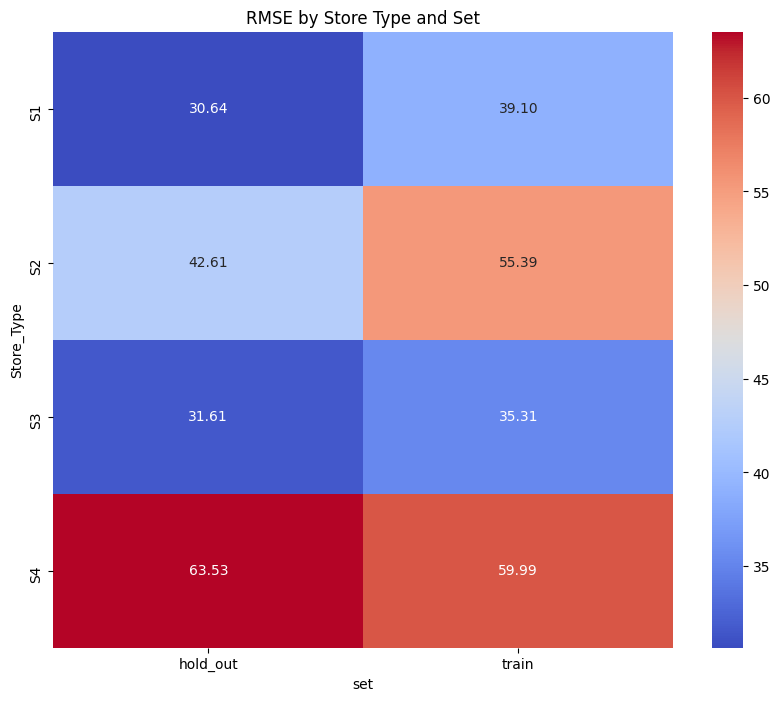

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error


  # Function to calculate RMSE
def calculate_rmse(group):
    actual = group['Orders_original']
    predicted = group['Predicted_Orders']
    rmse = sqrt(mean_squared_error(actual, predicted))
    return rmse

  # Apply the function to each group
rmse_by_store_type_and_set = df_analysis.loc[df_analysis['Predicted_Orders'].notnull()].groupby(['Store_Type', 'set']).apply(calculate_rmse)

  # Reset the index of the Series to make it a DataFrame
rmse_df = rmse_by_store_type_and_set.reset_index()

  # Rename the 0 column to 'RMSE'
rmse_df = rmse_df.rename(columns={0: 'RMSE'})

  # Create a pivot table for the heatmap
pivot = rmse_df.pivot(index='Store_Type', columns='set', values='RMSE')

  # Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('RMSE by Store Type and Set')
plt.show()


In [387]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

np.random.seed(42)  # Set the seed to an arbitrary number

plot_data = df_analysis.loc[df_analysis['Predicted_Orders'].notnull()]

samples = plot_data.loc[plot_data['set'] == 'hold_out']
samples = samples.sample(n=4, random_state=42)  # Set the seed for pandas sample method
samples_list = list(samples['Store_id'])

for store in samples_list:
  # Select the data for a specific store
  store_id = store  # replace with your store id
  df_store = plot_data[plot_data['Store_id'] == store_id]

  # Create a line plot of sales over time
  fig = go.Figure()

  # Add a line for original orders
  fig.add_trace(go.Scatter(x=df_store['Date'], y=df_store['Orders_original'], mode='lines', name='Orders'))

  # Add a line for predicted sales
  fig.add_trace(go.Scatter(x=df_store['Date'], y=df_store['Predicted_Orders'], mode='lines', name='Predicted Orders'))

  # Set the title
  fig.update_layout(title='Sales Over Time for Store {}'.format(store_id))

  fig.show()


In [388]:
plot_data['error'] = plot_data['Orders_original'] - plot_data['Predicted_Orders']

<ipython-input-388-dff4e64c1b6b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [389]:
import plotly.express as px

# Assuming 'category' is the name of your category column
fig = px.histogram(plot_data, x="error", color="set", nbins=1000,
                   labels={"error": "Error"},
                   title="Histogram of Error by Category",
                   template='plotly_white')

fig.show()


In [392]:
import json
import yaml

# Make sure to use double backslashes in your file path or raw string format
json_path = YOUR_DIRECTORY

# Load the JSON file
with open(json_path, 'r') as f:
    train_stats = json.load(f)

In [393]:
import plotly.graph_objects as go

# Extract losses
train_loss = train_stats['training']['Order_sequence_label_2019-05-31']['loss']
validation_loss = train_stats['validation']['Order_sequence_label_2019-05-31']['loss']
test_loss = train_stats['test']['Order_sequence_label_2019-05-31']['loss']

# Create list of epochs
epochs = list(range(1, len(train_loss) + 1))

# Create the plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training loss'))
fig.add_trace(go.Scatter(x=epochs, y=validation_loss, mode='lines', name='Validation loss'))
fig.add_trace(go.Scatter(x=epochs, y=test_loss, mode='lines', name='Test loss'))

# Add details
fig.update_layout(title='Training, Validation and Test Loss', xaxis_title='Epochs', yaxis_title='Loss')

# Show the plot
fig.show()
